# MDX 词典查询测试 - Yomitan 格式

本 Notebook 测试两种 MDX 查询格式:

1. **完整 HTML 格式** (`query_word`) - 用于预览和调试
2. **Yomitan 格式** (`query_multiple_dicts_yomitan`) - 用于 AnkiConnect 的 `definition`/`glossary` 字段

## Yomitan 格式说明

```html
<div style="text-align: left;" class="yomitan-glossary">
  <ol>
    <li data-dictionary="词典名"><i>(词典名)</i> <span>{{MDX HTML}}</span></li>
    <style>.yomitan-glossary [data-dictionary="词典名"] {{CSS}}</style>
    
    <li data-dictionary="另一个词典"><i>(另一个词典)</i> <span>{{MDX HTML}}</span></li>
    <style>.yomitan-glossary [data-dictionary="另一个词典"] {{CSS}}</style>
  </ol>
</div>
```

**关键特性**:
- ✅ 多词典条目整合到 `<ol>` 列表
- ✅ CSS 命名空间隔离（`data-dictionary` 属性）
- ✅ 图片自动转 base64 嵌入
- ✅ 与 Yomitan 浏览器插件格式兼容

---

In [31]:
import sys
from pathlib import Path

from bs4 import BeautifulSoup

from mdxscraper import Dictionary
from mdxscraper.core.renderer import merge_css, embed_images

In [32]:
def query_word_yomitan_format(mdx_file: Path, word: str, dict_name: str = None) -> tuple[str, str]:
    """查询单个词典并返回 Yomitan 格式的 HTML 和 CSS
    
    Args:
        mdx_file: MDX 词典文件路径
        word: 要查询的单词
        dict_name: 词典名称（用于 data-dictionary 属性）
        
    Returns:
        (html_content, css_content) 元组
    """
    if type(mdx_file) is not Path:
        mdx_file = Path(mdx_file)
    
    # 如果未指定词典名称，使用文件名（不含扩展名）
    if dict_name is None:
        dict_name = mdx_file.stem
    
    # 打开词典
    with Dictionary(mdx_file) as dict_obj:
        # 查询单词
        html_content = dict_obj.lookup_html(word)
        
        if not html_content:
            print(f"❌ 未找到单词 '{word}' (词典: {dict_name})", file=sys.stderr)
            return None, None
        
        # 提取词典 CSS
        dict_css = ""
        try:
            if '<link' in html_content.lower():
                temp_html = f"<html><head>{html_content}</head><body></body></html>"
                temp_soup = BeautifulSoup(temp_html, 'lxml')
                merged_soup = merge_css(temp_soup, mdx_file.parent, dict_obj.impl, None)
                
                if merged_soup.head and merged_soup.head.style:
                    dict_css = merged_soup.head.style.string or ""
                    if dict_css:
                        print(f"✅ [{dict_name}] 已提取 CSS ({len(dict_css)} 字符)")
        except Exception as e:
            print(f"ℹ️  [{dict_name}] 无法提取 CSS: {e}")
        
        # 嵌入图片（转为 base64）
        try:
            temp_soup = BeautifulSoup(f"<html><body>{html_content}</body></html>", 'lxml')
            embedded_soup = embed_images(temp_soup, dict_obj.impl)
            html_content = str(embedded_soup.body)
            html_content = html_content.replace('<body>', '').replace('</body>', '')
            print(f"✅ [{dict_name}] 已嵌入图片")
        except Exception as e:
            print(f"ℹ️  [{dict_name}] 无法嵌入图片: {e}")
        
        return html_content, dict_css


def add_css_namespace(css_content: str, dict_name: str) -> str:
    """为 CSS 规则添加词典命名空间
    
    Args:
        css_content: 原始 CSS 内容
        dict_name: 词典名称
        
    Returns:
        添加了命名空间的 CSS
    """
    if not css_content:
        return ""
    
    import re
    
    # 命名空间前缀
    namespace = f'.yomitan-glossary [data-dictionary="{dict_name}"]'
    
    # 处理 CSS 规则
    # 1. 移除注释
    css_no_comments = re.sub(r'/\*.*?\*/', '', css_content, flags=re.DOTALL)
    
    # 2. 分割成单独的规则
    # 匹配选择器 { 属性 } 的模式
    rules = []
    current_rule = ""
    brace_count = 0
    
    for char in css_content:
        current_rule += char
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0 and current_rule.strip():
                rules.append(current_rule.strip())
                current_rule = ""
    
    # 3. 为每个规则添加命名空间
    namespaced_rules = []
    for rule in rules:
        if not rule or '{' not in rule:
            continue
        
        # 分离选择器和属性
        match = re.match(r'(.+?)\s*\{(.+)\}', rule, re.DOTALL)
        if not match:
            continue
        
        selectors_str, properties = match.groups()
        
        # 分割多个选择器（用逗号分隔）
        selectors = [s.strip() for s in selectors_str.split(',')]
        
        # 为每个选择器添加命名空间
        namespaced_selectors = []
        for selector in selectors:
            if selector:
                # 在选择器前添加命名空间
                namespaced_selector = f"{namespace} {selector}"
                namespaced_selectors.append(namespaced_selector)
        
        # 重组规则
        if namespaced_selectors:
            namespaced_rule = ', '.join(namespaced_selectors) + ' {' + properties + '}'
            namespaced_rules.append(namespaced_rule)
    
    return '\n'.join(namespaced_rules)


def query_multiple_dicts_yomitan(mdx_files: list[tuple[Path, str]], word: str, output_file: Path = None) -> str:
    """查询多个词典并组合为 Yomitan 格式
    
    Args:
        mdx_files: [(mdx_path, dict_name), ...] 列表
        word: 要查询的单词
        output_file: 可选的输出文件路径
        
    Returns:
        完整的 Yomitan 格式 HTML（用于 definition/glossary 字段）
    """
    entries = []  # 存储每个词典的条目
    
    for mdx_file, dict_name in mdx_files:
        html_content, dict_css = query_word_yomitan_format(mdx_file, word, dict_name)
        
        if html_content:
            # 构建单个词典条目（Yomitan 格式）
            entry = f'<li data-dictionary="{dict_name}"><i>({dict_name})</i> <span>{html_content}</span></li>'
            
            # 如果有 CSS,添加 style 标签
            if dict_css:
                # 为 CSS 添加词典命名空间（正确处理每个选择器）
                namespaced_css = add_css_namespace(dict_css, dict_name)
                entry += f'<style>{namespaced_css}</style>'
            
            entries.append(entry)
    
    if not entries:
        print(f"❌ 所有词典中均未找到单词: {word}", file=sys.stderr)
        return None
    
    # 组合所有条目
    yomitan_html = f'<div style="text-align: left;" class="yomitan-glossary"><ol>{"".join(entries)}</ol></div>'
    
    # 保存到文件（如果指定）
    if output_file:
        # 构建完整的预览 HTML
        preview_html = f"""<!DOCTYPE html>
<html lang="zh-CN">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>{word} - Yomitan Preview</title>
</head>
<body style="background-color: #f5f5f5; padding: 20px;">
{yomitan_html}
</body>
</html>"""
        
        output_file.parent.mkdir(parents=True, exist_ok=True)
        output_file.write_text(preview_html, encoding='utf-8')
        print(f"✅ 已保存预览到: {output_file}")
        print(f"📊 总大小: {len(yomitan_html):,} 字符")
    
    return yomitan_html


# 保留原函数供单词典完整 HTML 输出使用
def query_word(mdx_file: Path, word: str, output_file: Path = None, embed_dict_images: bool = True) -> str:
    """查询单个词汇并返回完整 HTML（用于预览）
    
    Args:
        mdx_file: MDX 词典文件路径
        word: 要查询的单词
        output_file: 可选的输出文件路径
        embed_dict_images: 是否嵌入词典中的图片（base64）
        
    Returns:
        包含完整 CSS 的 HTML 字符串
    """

    if type(mdx_file) is not Path:
        mdx_file = Path(mdx_file)

    # 打开词典
    with Dictionary(mdx_file) as dict:
        # 查询单词（自动处理大小写、连字符等）
        html_content = dict.lookup_html(word)
        
        if not html_content:
            print(f"❌ 未找到单词: {word}", file=sys.stderr)
            return None
        
        # 使用 BeautifulSoup 解析 HTML
        soup = BeautifulSoup(html_content, 'lxml')
        
        # 尝试提取词典内部的 CSS
        dict_css = ""
        try:
            # 检查原始 HTML 是否包含 link 标签引用 CSS
            if '<link' in html_content.lower():
                # 创建完整的 HTML 结构供 merge_css 处理
                temp_html = f"<html><head>{html_content}</head><body></body></html>"
                temp_soup = BeautifulSoup(temp_html, 'lxml')
                
                # 调用 merge_css 提取并合并 CSS
                merged_soup = merge_css(temp_soup, mdx_file.parent, dict.impl, None)
                
                # 提取合并后的 CSS
                if merged_soup.head and merged_soup.head.style:
                    dict_css = merged_soup.head.style.string or ""
                    if dict_css:
                        print(f"✅ 已提取词典 CSS ({len(dict_css)} 字符)")
            else:
                print(f"ℹ️  词典内容未包含 CSS 引用")
        except Exception as e:
            print(f"ℹ️  无法提取词典 CSS: {e}")
            import traceback
            traceback.print_exc()
        
        # 如果需要嵌入图片
        if embed_dict_images:
            try:
                temp_soup = BeautifulSoup(f"<html><body>{html_content}</body></html>", 'lxml')
                embedded_soup = embed_images(temp_soup, dict.impl)
                # 更新 html_content
                html_content = str(embedded_soup.body)
                html_content = html_content.replace('<body>', '').replace('</body>', '')
                print(f"✅ 已嵌入词典图片")
            except Exception as e:
                print(f"ℹ️  无法嵌入图片: {e}")
        
        # 构建完整的 HTML 文档
        full_html = f"""<!DOCTYPE html>
<html lang="zh-CN">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>{word}</title>
    <style>
        /* ========== 词典内部 CSS ========== */
        {dict_css}
    </style>
</head>
<body>
{html_content}
</body>
</html>"""
        
        # 保存到文件（如果指定）
        if output_file:
            output_file.parent.mkdir(parents=True, exist_ok=True)
            output_file.write_text(full_html, encoding='utf-8')
            print(f"✅ 已保存到: {output_file}")
            print(f"📊 文件大小: {len(full_html):,} 字符")
        
        return full_html

In [33]:
res = query_word(r"E:\repos\Japanese-Anime-Text-Analysis\Anime_Texts\JP_Dics\DJS\DJS.mdx", "サボる")

✅ 已提取词典 CSS (1355 字符)
✅ 已嵌入词典图片


In [34]:
from IPython.display import HTML

# 添加白色背景的包装样式
styled_html = f"""
<div style="background-color: white; padding: 20px; border-radius: 8px;">
    {res}
</div>
"""

HTML(styled_html)

## Test 2: Yomitan 格式 - 多词典查询

测试 Yomitan 风格的多词典整合格式

In [35]:
# 定义多个词典（模拟 Yomitan 的多词典查询）
mdx_dicts = [
    (Path(r"E:\repos\Japanese-Anime-Text-Analysis\Anime_Texts\JP_Dics\DJS\DJS.mdx"), "大辞泉 第二版"),
    (Path(r"E:\repos\Japanese-Anime-Text-Analysis\Anime_Texts\JP_Dics\RHSJCD\日汉双解词典_20231101.mdx"), "日汉双解词典"),
    (Path(r"E:\repos\Japanese-Anime-Text-Analysis\Anime_Texts\JP_Dics\XSJRH\xsjrihanshuangjie.mdx"), "新世纪日汉双解词典"),
    # 如果有其他词典可以添加
    # (Path(r"path\to\another.mdx"), "另一个词典"),
]

# 查询单词 "政権"
word = "政権"
yomitan_html = query_multiple_dicts_yomitan(
    mdx_dicts, 
    word,
    output_file=Path("test_yomitan_format.html")
)

print("\n" + "="*50)
print("📋 Yomitan 格式 HTML 片段:")
print("="*50)
print(yomitan_html[:500] + "..." if len(yomitan_html) > 500 else yomitan_html)

✅ [大辞泉 第二版] 已提取 CSS (1355 字符)
✅ [大辞泉 第二版] 已嵌入图片
✅ [日汉双解词典] 已提取 CSS (3315 字符)
✅ [日汉双解词典] 已嵌入图片
✅ [新世纪日汉双解词典] 已提取 CSS (1576 字符)
✅ [新世纪日汉双解词典] 已嵌入图片
✅ 已保存预览到: test_yomitan_format.html
📊 总大小: 12,892 字符

📋 Yomitan 格式 HTML 片段:
<div style="text-align: left;" class="yomitan-glossary"><ol><li data-dictionary="大辞泉 第二版"><i>(大辞泉 第二版)</i> <span><link href="DJS.css" rel="stylesheet" type="text/css"/>
<div class="ex cf" lang="ja"><h3><hw>せい‐けん</hw>【政権】</h3><section class="description">政策を実行し、統治機構を動かす権力。「<spellout org="—">政権</spellout>を握る」「<spellout org="—">政権</spellout>政党」<br/><rect>類語</rect><a href="entry://しゅけん【主権】">主権</a>・<a href="entry://こっけん【国権】">国権</a>・<a href="entry://はけん【覇権】">覇権</a>・<a href="entry://しゅどうけん【主導権】">主導権</a...



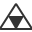

In [36]:
# 在 Notebook 中预览
from IPython.display import HTML

# 添加白色背景的包装样式
styled_html = f"""
<div style="background-color: white; padding: 20px; border-radius: 8px;">
    {yomitan_html}
</div>
"""

HTML(styled_html)

In [37]:
# 重新加载模块(避免缓存问题)
import sys
import importlib

# 清除已导入的 mdx_utils 模块
if 'mdx_utils' in sys.modules:
    del sys.modules['mdx_utils']
if 'mdx_utils.meanings_lookup' in sys.modules:
    del sys.modules['mdx_utils.meanings_lookup']
if 'mdx_utils.yomitan_formatter' in sys.modules:
    del sys.modules['mdx_utils.yomitan_formatter']

from pathlib import Path
from mdx_utils import MeaningsLookup

# 使用 from_dirs 初始化(推荐方式)
lookup = MeaningsLookup.from_dirs(
    primary_dir=Path(r"Anime_Texts\JP_Dics\DJS"),
    secondary_dir=Path(r"Anime_Texts\JP_Dics\RHSJCD"),

    dict_names={
        "DJS.mdx": "大辞泉 第二版",
        "日汉双解词典_20231101.mdx": "明鏡日汉双解辞典",
    },
    use_jamdict=True  # 启用 JMDict fallback
)

print(f"✅ 已加载 {len(lookup.all_dicts)} 个词典:")
for mdx_path, dict_name in lookup.all_dicts:
    print(f"   - {dict_name}")

# 查询单词(联合所有词典)
definition = lookup.lookup("政権")
print(f"\n✅ 查询结果长度: {len(definition)} 字符")

✅ 已加载 2 个词典:
   - 大辞泉 第二版
   - 明鏡日汉双解辞典

✅ 查询结果长度: 8373 字符


In [38]:
DICTS_DIR = Path(r"E:\repos\Japanese-Anime-Text-Analysis\Anime_Texts\JP_Dics")

# 只加载这里明确指定的词典
dict_names_map = {
    "DJS.mdx": "大辞泉 第二版",
    "日汉双解词典_20231101.mdx": "日汉双解词典",
    "xsjrihanshuangjie.mdx": "新世纪日汉双解词典",
    "NHKJPVDL.mdx": "NHK日本語発音アクセント辞書",
    # 可以继续添加其他词典的显示名称
}

# 构建 [(Path, 显示名称)] 列表 - 只加载 dict_names_map 中指定的文件
mdx_list = []
print(f"📚 加载指定的 {len(dict_names_map)} 个词典:")

for filename, display_name in dict_names_map.items():
    # 在所有子目录中搜索该文件
    found = False
    for subdir in DICTS_DIR.iterdir():
        if subdir.is_dir():
            mdx_path = subdir / filename
            if mdx_path.exists():
                mdx_list.append((mdx_path, display_name))
                print(f"   ✅ {display_name} ({filename})")
                found = True
                break
    
    if not found:
        print(f"   ❌ 未找到: {filename}")

print()

# 直接使用列表初始化
lookup = MeaningsLookup(mdx_list, use_jamdict=True)

print(f"✅ 已加载 {len(lookup.all_dicts)} 个词典")
for mdx_path, dict_name in lookup.all_dicts:
    print(f"   - {dict_name} ({mdx_path.name})")
print()


📚 加载指定的 4 个词典:
   ✅ 大辞泉 第二版 (DJS.mdx)
   ✅ 日汉双解词典 (日汉双解词典_20231101.mdx)
   ✅ 新世纪日汉双解词典 (xsjrihanshuangjie.mdx)
   ✅ NHK日本語発音アクセント辞書 (NHKJPVDL.mdx)

✅ 已加载 4 个词典
   - 大辞泉 第二版 (DJS.mdx)
   - 日汉双解词典 (日汉双解词典_20231101.mdx)
   - 新世纪日汉双解词典 (xsjrihanshuangjie.mdx)
   - NHK日本語発音アクセント辞書 (NHKJPVDL.mdx)



In [39]:
definition = lookup.lookup("庇う")
print(f"\n✅ 查询结果长度: {len(definition)} 字符")


✅ 查询结果长度: 17746 字符



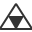

In [40]:
# 在 Notebook 中预览
from IPython.display import HTML

# 添加白色背景的包装样式
styled_html = f"""
<div style="background-color: white; padding: 20px; border-radius: 8px;">
    {definition}
</div>
"""

HTML(styled_html)

---

## Test 3: 音频和音调提取

测试从多个词典中提取音频和音调信息